# Brain MRI 去噪：配对监督训练（In → GT）

这个 Notebook 会：
1) 从两个文件夹读取 **输入噪声图像(In)** 与 **干净真值(GT)**（按文件名配对）
2) 训练一个轻量 UNet 去噪模型（PyTorch）
3) 在验证集上评估 PSNR/SSIM，并导出预测结果到 `outputs/`


In [45]:

# === 0. 环境准备 ===
import os, glob, random, math, time
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt


In [46]:

# 可选：安装依赖（如果你的环境没有）
# !pip -q install pillow matplotlib tqdm scikit-image


In [47]:

# === 1. 配置路径 & 训练参数 ===
GT_DIR = Path("/DATA/DATA1/lixinyue/code26/ppt/DB/GT")
IN_DIR = Path("/DATA/DATA1/lixinyue/code26/ppt/DB/In")

assert GT_DIR.exists(), f"GT_DIR not found: {GT_DIR}"
assert IN_DIR.exists(), f"IN_DIR not found: {IN_DIR}"

# 支持的图片后缀（按需加）
EXTS = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]

# 训练超参
IMG_SIZE = 256         # 统一 resize 到正方形（你也可以改成保持原分辨率训练）
BATCH_SIZE = 8
NUM_EPOCHS = 20
LR = 1e-3
VAL_RATIO = 0.2
SEED = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [48]:

# === 2. 文件配对：按文件名匹配 In ↔ GT ===
def list_images(folder: Path):
    files = []
    for ext in EXTS:
        files += list(folder.rglob(f"*{ext}"))
    return sorted(files)

gt_files = list_images(GT_DIR)
in_files = list_images(IN_DIR)

print(f"GT files: {len(gt_files)}")
print(f"In files: {len(in_files)}")

# 建立 {stem: path} 映射。stem = 不含后缀的文件名
def build_map(files):
    mp = {}
    for p in files:
        mp[p.stem] = p
    return mp

gt_map = build_map(gt_files)
in_map = build_map(in_files)

# 严格 stem 完全一致匹配
paired = []
for k, in_path in in_map.items():
    if k in gt_map:
        paired.append((in_path, gt_map[k]))

print(f"Paired (strict stem match): {len(paired)}")


GT files: 50
In files: 50
Paired (strict stem match): 50


In [49]:

# === 3. 划分 train / val ===
random.seed(SEED)
random.shuffle(paired)

n_total = len(paired)
n_val = int(n_total * VAL_RATIO)
val_pairs = paired[:n_val]
train_pairs = paired[n_val:]

print(f"Total: {n_total} | Train: {len(train_pairs)} | Val: {len(val_pairs)}")


Total: 50 | Train: 40 | Val: 10


In [50]:

# === 4. Dataset / Dataloader ===
class PairedDenoiseDataset(Dataset):
    def __init__(self, pairs, img_size=256):
        self.pairs = pairs
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def _load(self, path: Path):
        img = Image.open(path).convert("L")  # 灰度
        if self.img_size is not None:
            img = img.resize((self.img_size, self.img_size), Image.BICUBIC)
        arr = np.array(img).astype(np.float32) / 255.0  # [H,W] 0..1
        return arr

    def __getitem__(self, idx):
        in_path, gt_path = self.pairs[idx]
        x = self._load(in_path)
        y = self._load(gt_path)

        # [1,H,W]
        x = torch.from_numpy(x).unsqueeze(0)
        y = torch.from_numpy(y).unsqueeze(0)
        return x, y, str(in_path.name)

train_ds = PairedDenoiseDataset(train_pairs, IMG_SIZE)
val_ds = PairedDenoiseDataset(val_pairs, IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train batches: 5 Val batches: 2


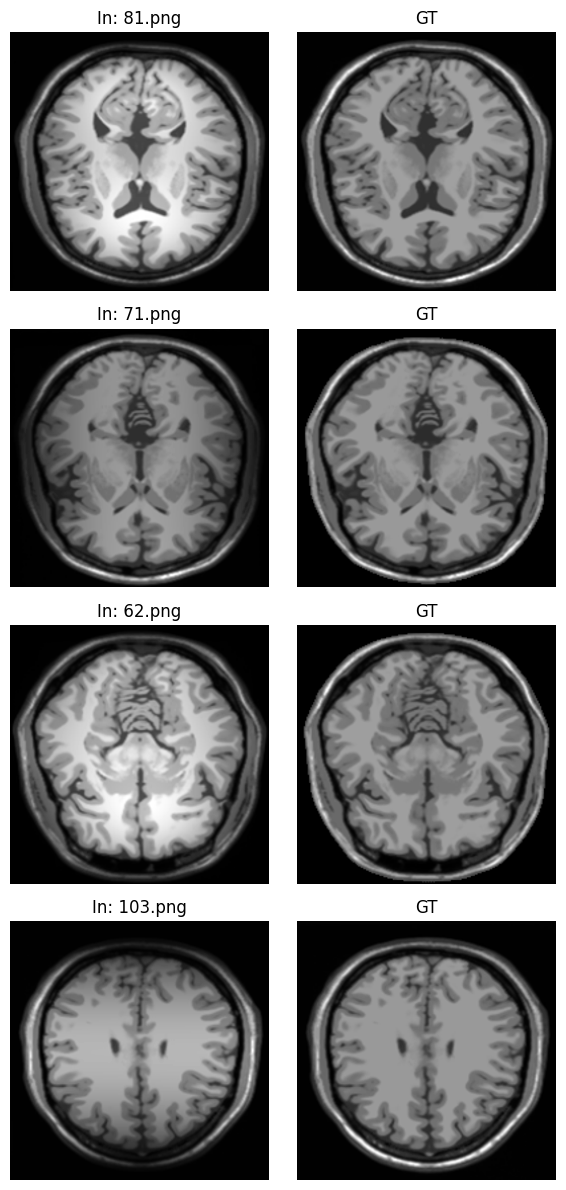

In [51]:

# === 5. 可视化几对样本 ===
def show_batch(ds, n=4):
    n = min(n, len(ds))
    fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
    for i in range(n):
        x, y, name = ds[i]
        axes[i,0].imshow(x.squeeze(0), cmap="gray")
        axes[i,0].set_title(f"In: {name}")
        axes[i,0].axis("off")
        axes[i,1].imshow(y.squeeze(0), cmap="gray")
        axes[i,1].set_title("GT")
        axes[i,1].axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_ds, n=4)


In [52]:

# === 6. 模型：轻量 UNet ===
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 对齐尺寸（防止奇数尺寸导致 mismatch）
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.inc = DoubleConv(in_ch, base)
        self.down1 = Down(base, base*2)
        self.down2 = Down(base*2, base*4)
        self.down3 = Down(base*4, base*8)
        self.up1 = Up(base*8, base*4)
        self.up2 = Up(base*4, base*2)
        self.up3 = Up(base*2, base)
        self.outc = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.outc(x)
        # 去噪输出通常 clip 到 [0,1]；训练时可不 clip，推理时 clip
        return x

model = UNetSmall().to(DEVICE)
print("Params:", sum(p.numel() for p in model.parameters())/1e6, "M")


Params: 1.927841 M


In [53]:

# === 7. 指标：PSNR / SSIM ===
from skimage.metrics import peak_signal_noise_ratio as psnr_fn
from skimage.metrics import structural_similarity as ssim_fn

@torch.no_grad()
def compute_metrics(pred, gt):
    # pred/gt: [B,1,H,W] torch
    pred = pred.clamp(0,1).cpu().numpy()
    gt = gt.clamp(0,1).cpu().numpy()
    psnrs, ssims = [], []
    for i in range(pred.shape[0]):
        p = pred[i,0]
        g = gt[i,0]
        psnrs.append(psnr_fn(g, p, data_range=1.0))
        ssims.append(ssim_fn(g, p, data_range=1.0))
    return float(np.mean(psnrs)), float(np.mean(ssims))


In [ ]:

# === 8. 训练循环 ===
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.L1Loss()  # 课堂建议先用 L1，稳定

def train_one_epoch():
    model.train()
    losses = []
    for x, y, _ in tqdm(train_loader, desc="Train", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def validate():
    model.eval()
    losses = []
    psnrs, ssims = [], []
    for x, y, _ in tqdm(val_loader, desc="Val", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        pred = model(x)
        loss = criterion(pred, y)
        losses.append(loss.item())
        p, s = compute_metrics(pred, y)
        psnrs.append(p)
        ssims.append(s)
    return float(np.mean(losses)), float(np.mean(psnrs)), float(np.mean(ssims))

history = {"train_l1": [], "val_l1": [], "val_psnr": [], "val_ssim": []}

best_val = 1e9
ckpt_path = Path("unet_denoise_best.pt")

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    tr = train_one_epoch()
    vl, vpsnr, vssim = validate()
    history["train_l1"].append(tr)
    history["val_l1"].append(vl)
    history["val_psnr"].append(vpsnr)
    history["val_ssim"].append(vssim)

    if vl < best_val:
        best_val = vl
        torch.save({"model": model.state_dict(), "epoch": epoch, "best_val": best_val}, ckpt_path)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | train L1={tr:.4f} | val L1={vl:.4f} | PSNR={vpsnr:.2f} | SSIM={vssim:.4f} | {dt:.1f}s")

print("Best checkpoint saved to:", ckpt_path)


Epoch 01/20 | train L1=0.1861 | val L1=0.2557 | PSNR=10.48 | SSIM=0.1250 | 0.6s


Epoch 02/20 | train L1=0.0746 | val L1=0.2174 | PSNR=12.31 | SSIM=0.2043 | 0.6s


Epoch 03/20 | train L1=0.0514 | val L1=0.1954 | PSNR=13.40 | SSIM=0.2709 | 0.6s


Val:   0%|          | 0/2 [00:00<?, ?it/s]          

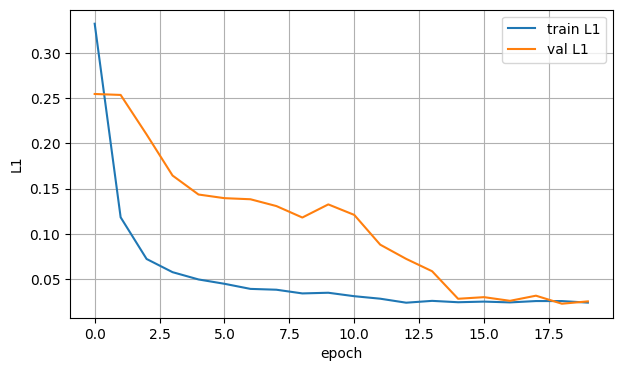

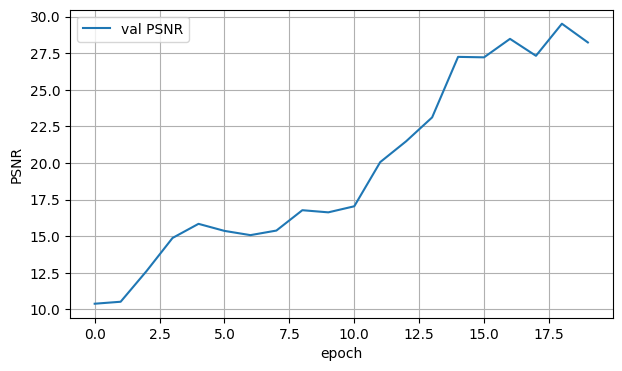

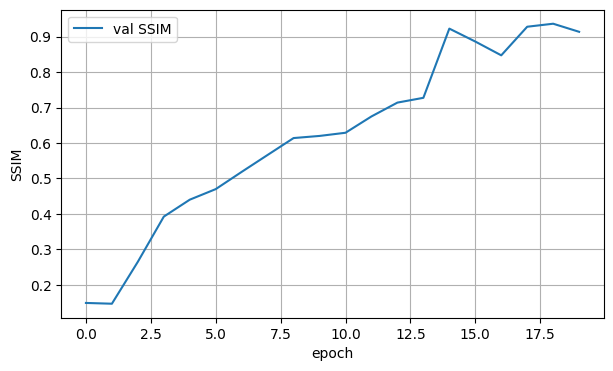

In [ ]:

# === 9. 训练曲线可视化 ===
plt.figure(figsize=(7,4))
plt.plot(history["train_l1"], label="train L1")
plt.plot(history["val_l1"], label="val L1")
plt.xlabel("epoch"); plt.ylabel("L1")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.plot(history["val_psnr"], label="val PSNR")
plt.xlabel("epoch"); plt.ylabel("PSNR")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.plot(history["val_ssim"], label="val SSIM")
plt.xlabel("epoch"); plt.ylabel("SSIM")
plt.legend(); plt.grid(True); plt.show()


In [ ]:

# === 10. 推理 & 导出结果 ===
# 加载最优模型
ckpt = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()
print("Loaded best model from epoch:", ckpt["epoch"], "best_val:", ckpt["best_val"])

out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True, parents=True)

@torch.no_grad()
def save_prediction(x, pred, name):
    # x/pred: [1,1,H,W]
    x_np = (x.squeeze().clamp(0,1).cpu().numpy() * 255.0).astype(np.uint8)
    p_np = (pred.squeeze().clamp(0,1).cpu().numpy() * 255.0).astype(np.uint8)
    Image.fromarray(x_np).save(out_dir / f"{Path(name).stem}_in.png")
    Image.fromarray(p_np).save(out_dir / f"{Path(name).stem}_pred.png")

# 对验证集导出（你也可以对全量 paired 导出）
for x, y, name in tqdm(val_loader, desc="Export", leave=False):
    x = x.to(DEVICE)
    pred = model(x)
    for i in range(x.size(0)):
        save_prediction(x[i:i+1], pred[i:i+1], name[i])

print("Saved predictions to:", out_dir.resolve())


Loaded best model from epoch: 19 best_val: 0.022990046069025993


Saved predictions to: /DATA/DATA1/lixinyue/code26/ppt/outputs


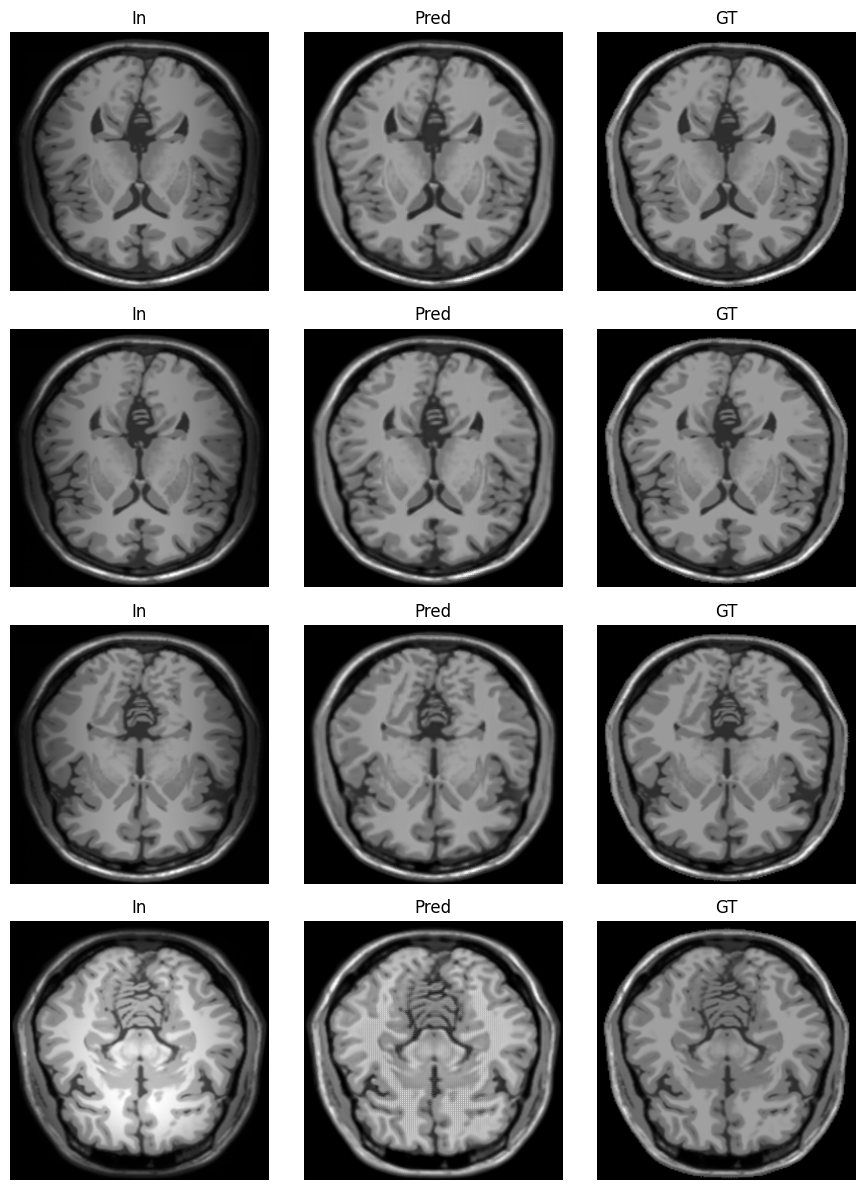

In [ ]:

# === 11. 对比可视化：In vs Pred vs GT ===
@torch.no_grad()
def show_results(ds, n=4):
    n = min(n, len(ds))
    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    for i in range(n):
        x, y, name = ds[i]
        x = x.unsqueeze(0).to(DEVICE)
        y = y.unsqueeze(0).to(DEVICE)
        pred = model(x)

        axes[i,0].imshow(x.squeeze().cpu(), cmap="gray")
        axes[i,0].set_title("In")
        axes[i,0].axis("off")

        axes[i,1].imshow(pred.squeeze().clamp(0,1).cpu(), cmap="gray")
        axes[i,1].set_title("Pred")
        axes[i,1].axis("off")

        axes[i,2].imshow(y.squeeze().cpu(), cmap="gray")
        axes[i,2].set_title("GT")
        axes[i,2].axis("off")
    plt.tight_layout()
    plt.show()

show_results(val_ds, n=4)
